# Active Kriging-Monte Carlo Simulation Example 1

Author: Mohit S. Chauhan 
Date: May 20, 2020

In this example, Monte Carlo Sampling is used to generate samples from Normal distribution and new samples are generated adaptively, using U-function as the learning criteria .

Import the necessary libraries. Here we import standard libraries such as numpy, matplotlib and other necessary library for plots, but also need to import the MCS, AKMCS, Kriging and RunModel class from UQpy.

In [1]:
from UQpy.Surrogates import Kriging
from UQpy.SampleMethods import MCS, AKMCS
from UQpy.RunModel import RunModel
from UQpy.Distributions import Normal
from series import series
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import time

Using UQpy MCS class to generate samples for two random variables, which are normally distributed with mean 0 and variance 1.

In [2]:
marginals = [Normal(loc=0., scale=4.), Normal(loc=0., scale=4.)]
x = MCS(dist_object=marginals, nsamples=20, random_state=1)

RunModel class is used to define an object to evaluate the model at sample points.

In [3]:
rmodel = RunModel(model_script='series.py', vec=False)

Krig class defines an object to generate an surrogate model for a given set of data.

In [4]:
K = Kriging(reg_model='Linear', corr_model='Exponential', corr_model_params=np.array([1, 1]), nopt=10)

This example works for all three learning function based on reliability analysis.

In [5]:
# OPTIONS: 'U', 'EFF', 'Weighted-U'
lf_name = 'Weighted-U'
# Default values for inbuilt functions
kw = {"u_stop": 2, "weighted_u_stop": 2, "eff_a": 0, "eff_epsilon": 2, "eff_stop": 0.001, 'eif_stop': 0.01}

AKMCS class is used to generate new sample using 'U-function' as active learning function.

In [6]:
start_time = time.time()
a = AKMCS(runmodel_object=rmodel, krig_object=K, nlearn=10**3, n_add=1, 
          learning_function=lf_name, dist_object=marginals, **kw, random_state=2)
a.run(nsamples=100, samples=x.samples)
elapsed_time = time.time() - start_time

In [7]:
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
g = a.krig_model(a.learning_set, False)
n_ = a.learning_set.shape[0] + len(a.qoi)
pf = (sum(g < 0) + sum(np.array(a.qoi) < 0)) / n_
print('Time: ', elapsed_time)
print('Function evaluation: ', a.samples.shape[0])
print('Probability of failure: ', pf)

Time:  3.3110828399658203
Function evaluation:  100
Probability of failure:  [0.60363636]


This figure shows the location of new samples generated using active learning function.

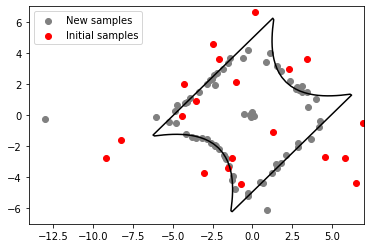

In [8]:
num = 50
x1 = np.linspace(-7, 7, num)
x2 = np.linspace(-7, 7, num)
x1v, x2v = np.meshgrid(x1, x2)
y = np.zeros([num, num])
y_act = np.zeros([num, num])
mse = np.zeros([num, num])
for i in range(num):
    for j in range(num):
        xa = marginals[0].cdf(np.atleast_2d(x1v[i, j]))
        ya = marginals[1].cdf(np.atleast_2d(x2v[i, j]))
        y[i, j] = a.krig_model(np.hstack([xa, ya]))
        y_act[i, j] = series(np.array([[x1v[i, j], x2v[i, j]]]))

fig, ax = plt.subplots()
kr_a = ax.contour(x1v, x2v, y_act, levels=[0], colors='Black')

# Plot for scattered data
nd = x.nsamples
ID1 = ax.scatter(a.samples[nd:, 0], a.samples[nd:, 1], color='Grey', label='New samples')
ID = ax.scatter(x.samples[:nd, 0], x.samples[:nd, 1], color='Red', label='Initial samples')
plt.legend(handles=[ID1, ID])
plt.show()

## User-define Learning function

In [9]:
def u_function(surr, pop, **kwargs):
    # AKMS class use these inputs to compute the learning function
    n_add = kwargs['n_add']
    parameters = kwargs['parameters']
      
    g, sig = surr(pop, True)

    # Remove the inconsistency in the shape of 'g' and 'sig' array
    g = g.reshape([pop.shape[0], 1])
    sig = sig.reshape([pop.shape[0], 1])

    u = abs(g) / sig
    rows = u[:, 0].argsort()[:n_add]

    indicator = False
    if min(u[:, 0]) >= parameters['u_stop']:
        indicator = True

    return pop[rows, :], u[rows, 0], indicator

Creating new instances of Kriging and RunModel class.

In [10]:
K1 = Kriging(reg_model='Linear', corr_model='Exponential', corr_model_params=np.array([1, 1]), nopt=10)
rmodel1 = RunModel(model_script='series.py', vec=False)

Executing AKMCS with the user-defined learning function.

In [ ]:
start_time = time.time()
ak = AKMCS(runmodel_object=rmodel1, samples=x.samples, krig_object=K1, nlearn=10**3, n_add=1, learning_function=u_function,
           dist_object=marginals, random_state=3, **kw)
ak.run(nsamples=100)
elapsed_time = time.time() - start_time

In [ ]:
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
g = ak.krig_model(ak.learning_set, False)
n_ = ak.learning_set.shape[0] + len(ak.qoi)
pf = (sum(g < 0) + sum(np.array(ak.qoi) < 0)) / n_
print('Time: ', elapsed_time)
print('Function evaluation: ', ak.samples.shape[0])
print('Probability of failure: ', pf)

This figure shows the location of new samples generated using active learning function.

In [ ]:
fig1, ax1 = plt.subplots()
kr_a = ax1.contour(x1v, x2v, y_act, levels=[0], colors='Black')

# Plot for scattered data
ID1 = ax1.scatter(ak.samples[nd:, 0], ak.samples[nd:, 1], color='Grey', label='New samples')
ID = ax1.scatter(x.samples[:nd, 0], x.samples[:nd, 1], color='Red', label='Initial samples')
plt.legend(handles=[ID1, ID])
plt.show()

## Monte Carlo Simulation

Probability of failure and covariance is estimated using Monte Carlo Simulation. 10,000 samples are generated randomly using MCS class and model is evaluated at all samples. 

In [ ]:
start_time = time.time()

# Code
b = MCS(dist_object=marginals, nsamples=10**4, random_state=4)
r1model = RunModel(model_script='series.py', vec=False)
r1model.run(samples=b.samples)
gx = np.array(r1model.qoi_list)
pf_mcs = np.sum(np.array(gx) < 0)/b.nsamples
cov_pf_mcs = np.sqrt((1 - pf_mcs)/(pf_mcs * b.nsamples))

elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

Results from Monte Carlo Simulation.

In [ ]:
print('Time: ', elapsed_time)
print('Function evaluation: ', b.nsamples)
print('Probability of failure: ', pf_mcs)